In [1]:
import pandas as pd
import numpy
import networkx as nx 
import dynetx as dn
import matplotlib.pyplot as plt
import random
from alive_progress import alive_bar
import time
from collections import defaultdict
import seaborn as sns
from igraph import Graph

In [2]:
def n_m_anonymity(G):
    
    # Create ego network
    ego_properties = {}
    
    # Obtain (n, m) value for each node
    for node in range(G.vcount()):
        ego_net = G.subgraph(G.neighborhood(node))
        
        n = ego_net.vcount()
        m = ego_net.ecount()
        
        ego_properties[node] = (n, m)
    
    # Store nodes as keys and the frequency of its (n,m) in the network as values
    frequency_dict = {}
    for node, (n, m) in ego_properties.items():
        freq_count = sum(1 for props in ego_properties.values() if props == (n, m))
        frequency_dict[node] = freq_count
    
    # Calculate the percentage of nodes with unique (n, m) values (frequency of 1)
    unique_count = sum(1 for count in frequency_dict.values() if count == 1)
    total_nodes = G.vcount()
    percentage_unique = (unique_count / total_nodes) * 100  
    
    return frequency_dict

In [3]:
def betweenness_centra_ig(G):
    betweenness_centrality = G.betweenness(directed=True)

    betweenness_ranking = {node: centrality for node, centrality in sorted(zip(range(len(betweenness_centrality)), betweenness_centrality), key=lambda x: x[1], reverse=True)}
    
    return betweenness_ranking

In [21]:
def snapshots_uniqueness_betweenness(edges, step=0.02, part=1):
    unique_top10 = []
    unique_mid10 = []
    unique_last10 = []
    unique_start10 = []
    unique_percentage = []
    count = []
    precision = []
    recall = []
    nodes_num = []
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    M = G.number_of_edges()

    for i in range(11, int(part*M), int(step*M)):
        # Create Snapshot
        sub_edge = edges[:i]
        snapshot = Graph.TupleList(sub_edge, directed=True)
        N = snapshot.vcount()
            
        # Calculate (n, m) anonymity
        anonymity_dict = n_m_anonymity(snapshot)
        unique_count = sum(1 for count in anonymity_dict.values() if count == 1)
        percentage_unique = (unique_count / N) * 100
        
        # Calculate betweenness Ranking
        #rank = betweenness_centra(snapshot)
        rank = betweenness_centra_ig(snapshot)

        # top_10 = list(rank.keys())[:int(0.1 * len(rank))]
        # last_10 = list(rank.keys())[int(0.9 * len(rank)):]
        # start_10 = list(rank.keys())[int(0.1 * len(rank)) : int(0.2 * len(rank))]
        # mid_10 = list(rank.keys())[int(0.4 * len(rank)) : int(0.5 * len(rank))]
        top_10 = list(rank.keys())[:int(0.1 * N)]
        last_10 = list(rank.keys())[int(0.9 * N):]
        start_10 = list(rank.keys())[int(0.1 * N) : int(0.2 * N)]
        mid_10 = list(rank.keys())[int(0.4 * N) : int(0.5 * N)]
        
        # Precision: In the retrieved top 10% nodes, how many are indeed unique
        
        top_10_percent_nodes_values = {node: anonymity_dict[node] for node in top_10}
        mid_10_percent_nodes_values = {node: anonymity_dict[node] for node in mid_10}
        last_10_percent_nodes_values = {node: anonymity_dict[node] for node in last_10}
        start_10_percent_nodes_values = {node: anonymity_dict[node] for node in start_10}
        
        # Top 10%
        unique_count_top = sum(1 for count in top_10_percent_nodes_values.values() if count == 1)
        unique_top10.append(unique_count_top)
        # mid 10%
        unique_count_mid = sum(1 for count in mid_10_percent_nodes_values.values() if count == 1)
        unique_mid10.append(unique_count_mid)     
        # Last 10%
        unique_count_last = sum(1 for count in last_10_percent_nodes_values.values() if count == 1)
        unique_last10.append(unique_count_last)
        # 10%-20%
        unique_count_start = sum(1 for count in start_10_percent_nodes_values.values() if count == 1)
        unique_start10.append(unique_count_start)
        
        
        # Precision: In the retrieved top 10% nodes, how many are indeed unique
        precision.append(unique_count_top/len(top_10))
        # Recall: Out of all unique nodes, how many are retrieved in top 10%
        recall.append(unique_count_top/unique_count)
        nodes_num.append(N)
        count.append(unique_count)
        unique_percentage.append(percentage_unique)
             
    return count, unique_percentage, nodes_num, unique_top10, unique_mid10, unique_last10, unique_start10, precision, recall

In [5]:
# Func 4: Plotting 
def plot_uniquecount(count):
    plt.plot(count, linestyle='-', color='b')
    #plt.plot(unique_percentage, linestyle='-', color='r')
    plt.xlabel('Snapshot')
    plt.ylabel('Unique Node Number')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    plt.title('Unique Node Percentage for Each Snapshot')
    #plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()
    
    
def plot_uniquepercent(count, percent):
    fig, ax1 = plt.subplots()
    #ax1.set_lable('Network Develop with timestamps')
    ax1.set_ylabel('Percentage of unique nodes/%')
    ax1.plot(percent, linestyle='-', color='b', label='uniqueness percentage')

    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('No. of Unique nodes')
    ax2.plot(count, linestyle='-', color='r', label='No. of unique nodes')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  


def plot_uniquecentrality(count, top, mid, last, start):
    plt.plot(count, linestyle='-', color='b', label='Full Snapshot')
    plt.plot(top, linestyle='-', color='r', label='Top 10% Betweenness')
    plt.plot(start, linestyle='-', color='purple', label='Top 10%-20% Betweenness')
    plt.plot(mid, linestyle='-', color='g', label='Middle Betweenness (40-50%)')
    plt.plot(last, linestyle='-', color='y', label='Last 10% Betweenness')
    
    plt.xlabel('Network Develop with timestamps')
    plt.ylabel('No. of unique nodes')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    plt.title('Number of unique nodes for Each Snapshot with (n, m) size of 1')
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  
    

def plot_uniqueproperty(count, percent, avg_degree, top_closeness):
    fig, ax1 = plt.subplots()
    #ax1.set_xlable('Snapshot at Timestamp')
    ax1.set_ylabel('Percentage of unique nodes')
    ax1.plot(percent, linestyle='-', color='b', label='Full Snapshot')
    ax1.plot(top_closeness, linestyle='-', color='y', label='Top 10% Closeness')
    # ax1.tick_params(axis='y')
    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Degree/Distance')

    ax2.plot(avg_degree, linestyle='-', color='r', label='Average Degree')
    #ax2.plot(avg_dist, linestyle='-', color='g', label='Average Distance')
    # plt.plot(density, linestyle='-', color='purple', label='Density')
    # ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xlabel('Network Develop with timestamps')
    plt.xticks(range(0, 51, 10), [f'{i}% ' for i in range(0, 101, 20)])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  
    

In [33]:
def plot_data(count, nodes_num, precision, recall):
    fig, ax1 = plt.subplots()
    #ax1.set_xlable('Snapshot at Timestamp')
    ax1.set_ylabel('Uniqueness')
    ax1.plot(count, linestyle='-', color='b', label='Full Snapshot Unique nodes')
    ax1.plot(nodes_num, linestyle='-', color='y', label='No. of nodes')
    # ax1.tick_params(axis='y')
    plt.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel('Betweenness Top 10%')

    ax2.plot(precision, linestyle='-', color='r', label='Precision')
    ax2.plot(recall, linestyle='-', color='g', label='Recall')
    # plt.plot(density, linestyle='-', color='purple', label='Density')
    # ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Unique Node Percentage for Each Snapshot with (n, m) size of 1')
    plt.xlabel('Network Develop with timestamps')
    plt.xticks(range(0, len(count), 10), [f'{i}% ' for i in range(0, 101, 10*int(100/len(count)))])
    # plt.xticks(range(len(unique_percentage)), range(len(unique_percentage)))
    plt.legend()
    plt.show()  

### Dataset 1

In [6]:
edge_list_file = 'data/ia-reality-call.edges'
edges = []

with open(edge_list_file, 'r') as file:
    for line in file:
        source, target, _ = map(int, line.strip().split(',')[:3])
        edge = (source, target)
        if edge not in edges:
            edges.append(edge)   # dropping repeating edges, each edge only appear once

G = nx.DiGraph()
G.add_edges_from(edges)
print(G.number_of_nodes())
print(G.number_of_edges())

6809
9484


In [7]:
count, unique_percentage, nodes_num, top, mid, last, start, precision, recall = snapshots_uniqueness_betweenness(edges)

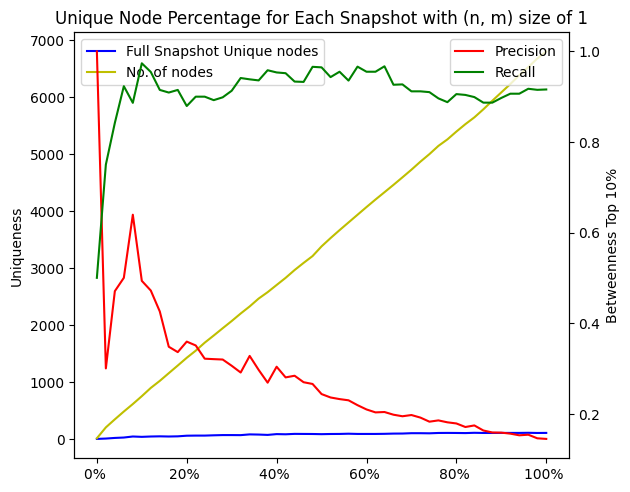

In [10]:
plot_data(count, nodes_num, precision, recall)

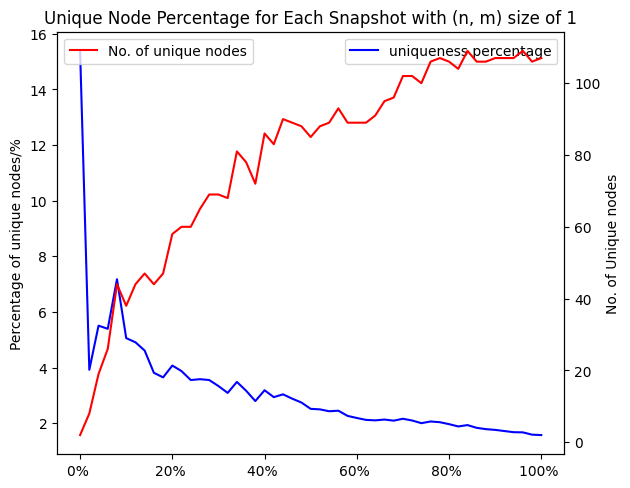

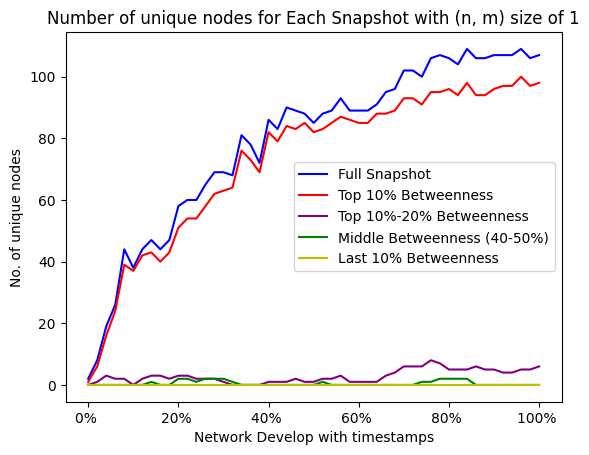

In [11]:
plot_uniquepercent(count, unique_percentage)
plot_uniquecentrality(count, top, mid, last, start)

### DA2

In [14]:
with open('data/mooc_actions.tsv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list2 = []
for line in lines:
    parts = line.split()
    source = int(parts[1])
    target = int(parts[2])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list2.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list2)
print(G.number_of_nodes())
print(G.number_of_edges())

# edge_list_file = 'data/mooc_actions.tsv'
# edges2 = []

# with open(edge_list_file, 'r') as file:
#     for line in file:
#         source, target = map(int, line.strip().split(',')[1:3])
#         edge = (source, target)
#         if edge not in edges2:
#             edges2.append(edge)   # dropping repeating edges, each edge only appear once

7047
178406


In [15]:
count2, unique_percentage2, nodes_num2, top2, mid2, last2, start2, precision2, recall2 = snapshots_uniqueness_betweenness(edge_list2)

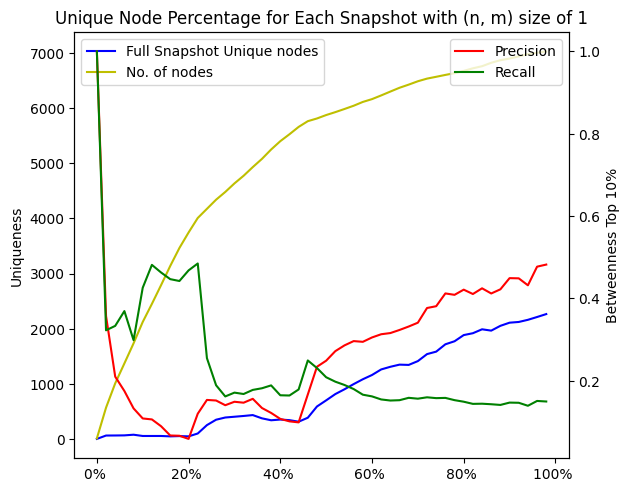

In [16]:
plot_data(count2, nodes_num2, precision2, recall2)

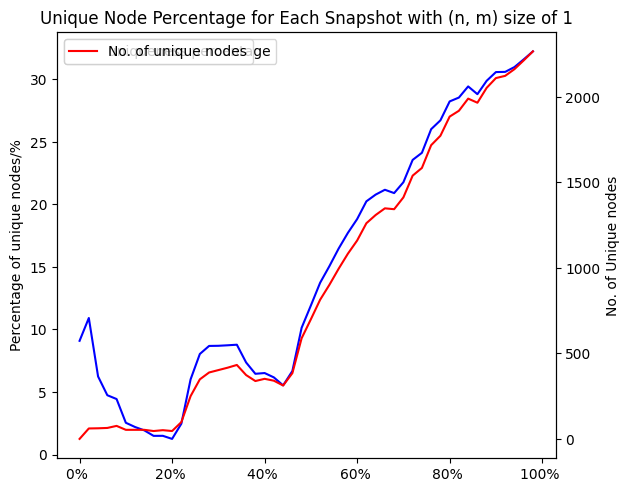

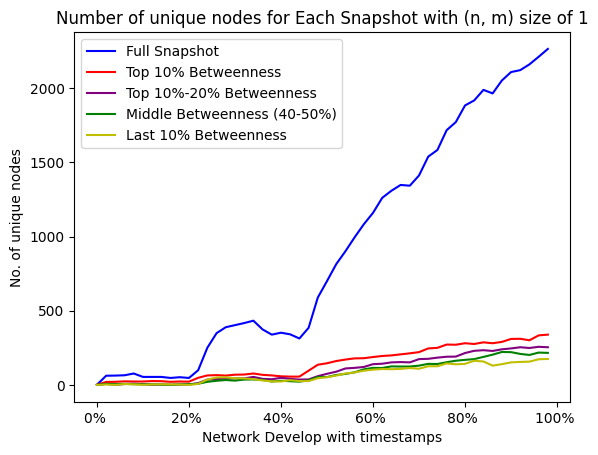

In [17]:
plot_uniquepercent(count2, unique_percentage2)
plot_uniquecentrality(count2, top2, mid2, last2, start2)

### DA 3

In [18]:
edge_list_file = 'data/ia-contacts_hypertext2009.edges'
edges3 = []

with open(edge_list_file, 'r') as file:
    for line in file:
        source, target, _ = map(int, line.strip().split(',')[:3])
        edge = (source, target)
        if edge not in edges3:
            edges3.append(edge)   # dropping repeating edges, each edge only appear once

G = nx.DiGraph()
G.add_edges_from(edges3)
print(G.number_of_nodes())
print(G.number_of_edges())

113
2498


In [22]:
count3, unique_percentage3, nodes_num3, top3, mid3, last3, start3, precision3, recall3 = snapshots_uniqueness_betweenness(edges3)

ZeroDivisionError: division by zero

### DATA4

In [23]:
with open('data/facebook_wall.csv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list4 = []
for line in lines:
    parts = line.split(',')
    source = int(parts[0])
    target = int(parts[1])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list4.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list4)
print(G.number_of_nodes())
print(G.number_of_edges())

45813
264004


In [24]:
count4, unique_percentage4, nodes_num4, top4, mid4, last4, start4, precision4, recall4 = snapshots_uniqueness_betweenness(edge_list4)

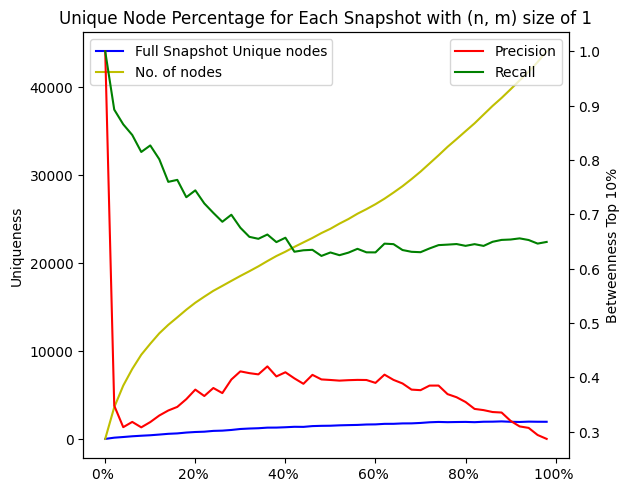

In [25]:
plot_data(count4, nodes_num4, precision4, recall4)

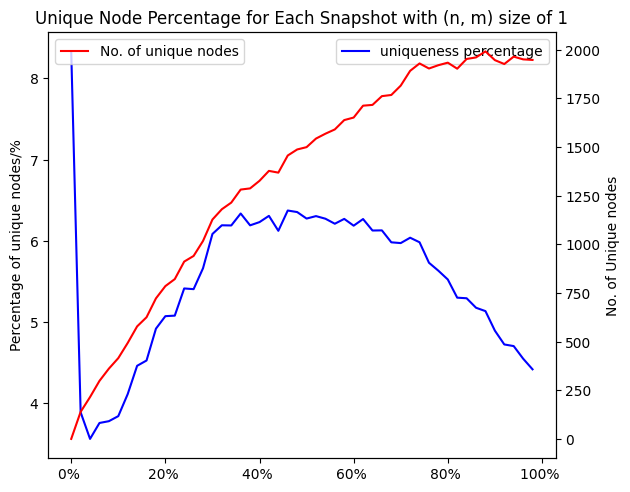

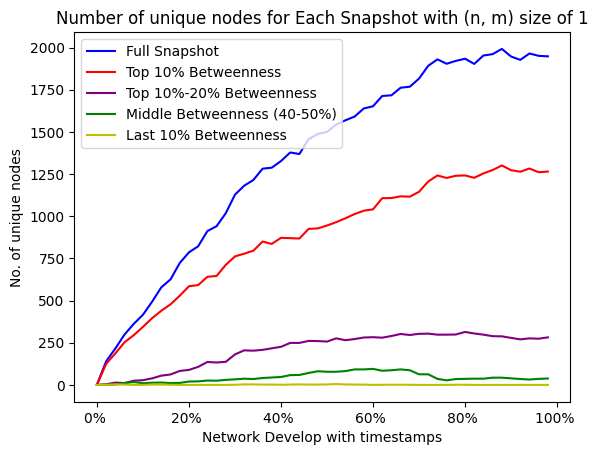

In [26]:
plot_uniquepercent(count4, unique_percentage4)
plot_uniquecentrality(count4, top4, mid4, last4, start4)

### DATA5

In [27]:
with open('data/sp_infections.csv', 'r') as file:
    # ignoring the first row since they are labels
    lines = file.readlines()[1:]

unique_edges = set()
edge_list5 = []
for line in lines:
    parts = line.split(',')
    source = int(parts[0])
    target = int(parts[1])
    # Ignore self-edges and repeating edges
    if source != target and (source, target) not in unique_edges:
        edge_list5.append((source, target))
        unique_edges.add((source, target))

G = nx.DiGraph()
G.add_edges_from(edge_list5)
print(G.number_of_nodes())
print(G.number_of_edges())

10972
52761


In [28]:
count5, unique_percentage5, nodes_num5, top5, mid5, last5, start5, precision5, recall5 = snapshots_uniqueness_betweenness(edge_list5)

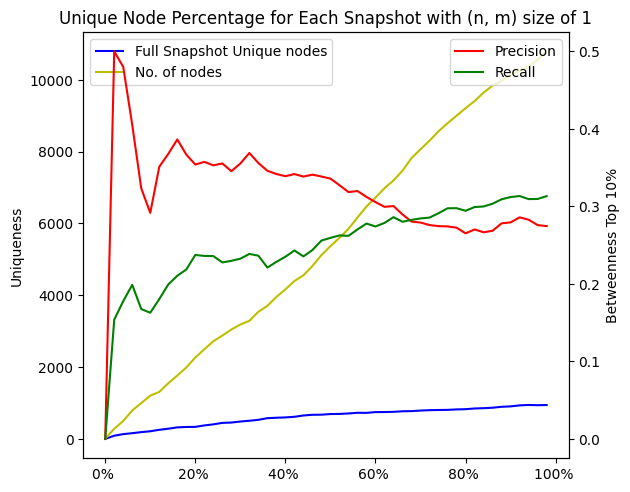

In [29]:
plot_data(count5, nodes_num5, precision5, recall5)

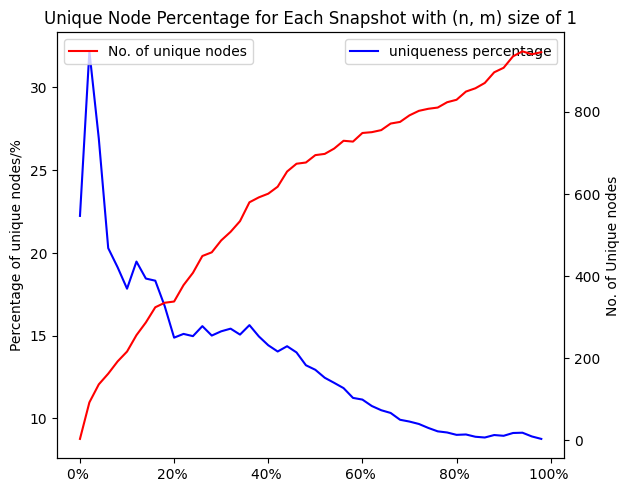

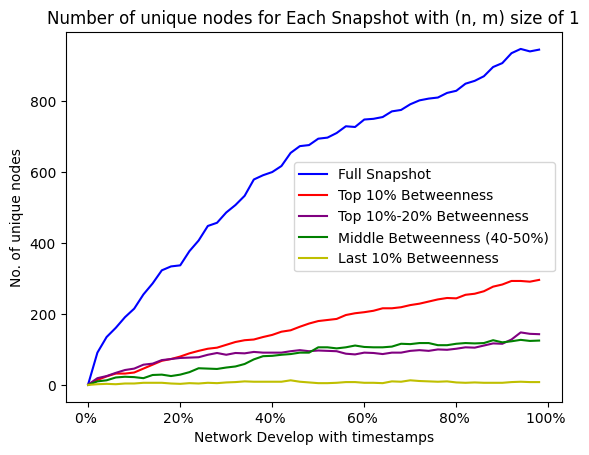

In [30]:
plot_uniquepercent(count5, unique_percentage5)
plot_uniquecentrality(count5, top5, mid5, last5, start5)

## Maturing Phase

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

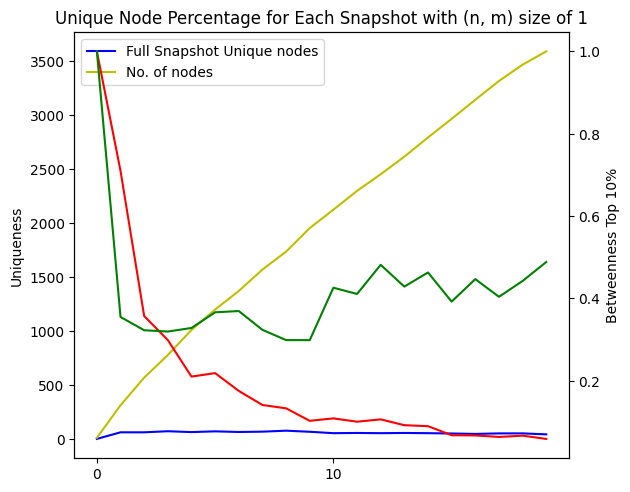

In [35]:
count1a, unique_percentage1a, nodes_num1a, top1a, mid1a, last1a, start1a, precision1a, recall1a = snapshots_uniqueness_betweenness(edge_list2, step=0.01, part=0.2)
plot_data(count1a, nodes_num1a, precision1a, recall1a)